In [1]:
# Imports
import numpy
import matplotlib.pyplot as plt
import scipy.io

In [2]:
# Declarations

# Paths
SUBJECT_A_TRAIN_PATH = '../dataset/Matlab Format/Subject_A_Train.mat'
SUBJECT_B_TRAIN_PATH = '../dataset/Matlab Format/Subject_B_Train.mat'

# Input Constants
EXTRACTED_CHANNEL = 10 #Cz
START_WINDOW = 0
END_WINDOW = 170

# 6x6 Grid That Is Displayed To The User
MATRIX = numpy.array([['A', 'B', 'C', 'D', 'E', 'F'], \
                      ['G', 'H', 'I', 'J', 'K', 'L'], \
                      ['M', 'N', 'O', 'P', 'Q', 'R'], \
                      ['S', 'T', 'U', 'V', 'W', 'X'], \
                      ['Y', 'Z', '1', '2', '3', '4'], \
                      ['5', '6', '7', '8', '9', '_']])

In [3]:
# Loading Data
Subject_A_Train = scipy.io.loadmat(SUBJECT_A_TRAIN_PATH)
Subject_B_Train = scipy.io.loadmat(SUBJECT_B_TRAIN_PATH)

In [4]:
# Detection

# A
#Train
Subject_A_Signal_Train = numpy.array(Subject_A_Train.get('Signal'));
Subject_A_TargetChar_Train = numpy.array(Subject_A_Train.get('TargetChar'));
Subject_A_StimulusCode_Train = numpy.array(Subject_A_Train.get('StimulusCode'));
print('A Train')
print('Subject A Signal Train:', Subject_A_Signal_Train.shape)
print('Subject A TargetChar Train:', Subject_A_TargetChar_Train.shape)
print('Subject A StimulusCode Train:', Subject_A_StimulusCode_Train.shape)

# B
Subject_B_Signal_Train = numpy.array(Subject_B_Train.get('Signal'));
Subject_B_TargetChar_Train = numpy.array(Subject_B_Train.get('TargetChar'));
Subject_B_StimulusCode_Train = numpy.array(Subject_B_Train.get('StimulusCode'));
print('\nB Train')
print('Subject B Signal Train:', Subject_B_Signal_Train.shape)
print('Subject B TargetChar Train:', Subject_B_TargetChar_Train.shape)
print('Subject B StimulusCode Train:', Subject_B_StimulusCode_Train.shape)

A Train
Subject A Signal Train: (85, 7794, 64)
Subject A TargetChar Train: (1,)
Subject A StimulusCode Train: (85, 7794)

B Train
Subject B Signal Train: (85, 7794, 64)
Subject B TargetChar Train: (1,)
Subject B StimulusCode Train: (85, 7794)


In [5]:
# Function To Get Average Of All Signals (And Channels) Within 1 Run
def get_runs_average(
        signals,
        stimulus_code,
        matrix,
        repeatitions = 15,
        start_window = 0,
        end_window = 240
    ):
    
    window = end_window - start_window
    responses = numpy.zeros((signals.shape[0], matrix.shape[0] + matrix.shape[1], window, signals.shape[2]))
    
    for epoch in range(signals.shape[0]):
        
        # Sum of All Repeatitions -> Division of Sum -> Average
        for n in range(1, signals.shape[1]):
            if stimulus_code[epoch, n] == 0 and stimulus_code[epoch, n - 1] != 0:
                responses[epoch, int(stimulus_code[epoch, n - 1]) - 1] += signals[epoch, n + start_window - 24 : n + end_window - 24]
        responses[epoch] = responses[epoch] / repeatitions
    
    return responses

# A
Subject_A_Average_Signal_Train = get_runs_average(
    Subject_A_Signal_Train,
    Subject_A_StimulusCode_Train,
    MATRIX,
    start_window=START_WINDOW,
    end_window=END_WINDOW
)
print('Subject A Average Signal Train:', Subject_A_Average_Signal_Train.shape)

# B
Subject_B_Average_Signal_Train = get_runs_average(
    Subject_B_Signal_Train,
    Subject_B_StimulusCode_Train,
    MATRIX,
    start_window=START_WINDOW,
    end_window=END_WINDOW
)
print('\nSubject B Average Signal Train:', Subject_B_Average_Signal_Train.shape)

Subject A Average Signal Train: (85, 12, 170, 64)

Subject B Average Signal Train: (85, 12, 170, 64)


In [6]:
# Function To Get Average Of All Signals (And Channels) Within 1 Session
def get_sessions_average(
        average_signals,
        target_char,
        matrix,
        repeatitions = 15,
        start_window = 0,
        end_window = 240
    ):
    
    window = end_window - start_window
    intensifications = matrix.shape[0] + matrix.shape[1]
    sum_responses_Success = numpy.zeros((window, average_signals.shape[3]))
    sum_responses_Fail = numpy.zeros((window, average_signals.shape[3]))
    
    # Looping Through Characters (85 Character)
    for epoch in range(average_signals.shape[0]):
        
        # Getting Index Of Chosen Character
        indices = numpy.where(matrix == target_char[epoch])
        chosen_column = indices[1][0]
        chosen_row = indices[0][0] + matrix.shape[1]
        
        for row_column in range(intensifications):
            if row_column == chosen_row or row_column == chosen_column:
                sum_responses_Success += average_signals[epoch, row_column]
            else:
                sum_responses_Fail += average_signals[epoch, row_column]

    average_responses_Success = sum_responses_Success / (average_signals.shape[0] * 2)
    average_responses_Fail = sum_responses_Fail / (average_signals.shape[0] * (intensifications - 2))
    
    return average_responses_Success, average_responses_Fail

# A
A_Success, A_Fail = get_sessions_average(
    Subject_A_Average_Signal_Train,
    Subject_A_TargetChar_Train[0],
    MATRIX,
    start_window=START_WINDOW,
    end_window=END_WINDOW
)

# B
B_Success, B_Fail = get_sessions_average(
    Subject_B_Average_Signal_Train,
    Subject_B_TargetChar_Train[0],
    MATRIX,
    start_window=START_WINDOW,
    end_window=END_WINDOW
)

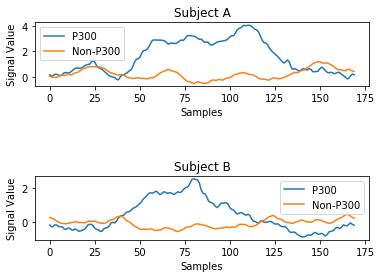

In [7]:
# Plotting

# A
ax1 = plt.subplot(3, 1, 1)
ax1.plot(A_Success[:, EXTRACTED_CHANNEL])
ax1.plot(A_Fail[:, EXTRACTED_CHANNEL])
ax1.set_title('Subject A')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Signal Value')
ax1.legend(('P300', 'Non-P300'))

# B
ax2 = plt.subplot(3, 1, 3)
ax2.plot(B_Success[:, EXTRACTED_CHANNEL])
ax2.plot(B_Fail[:, EXTRACTED_CHANNEL])
ax2.set_title('Subject B')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Signal Value')
ax2.legend(('P300', 'Non-P300'))